# Good, old-fashioned image processing

### Quentin Caudron, PhD
#### @QuentinCaudron

#### Data Scientist, CBRE - *we're hiring at `cbredev.com`*



<img src="talk/widefield_human_mask.jpg" width="900px" />

Talks this morning using neural nets for improc

Show you how to segment images : detect different objects

Wanted to present a more traditional approach

<img src="talk/lightning/romain.jpg" />

That's because this story started in 2013, ancient history for machine learning

Met Romain, started talking about upcoming huge image dataset

"I'll probably have to label images by hand."

"Oh, I'm going to analyse the images by hand. How else would you do it ?"

<center><img src="talk/lightning/coffee.jpg" /></center>

Couldn't handle; got coffee, collected my thoughts

Started a collaboration to capture and analyse images

#### Early images were of fantastic quality, and our algorithms worked out of the box.

<img src="talk/lightning/early_photos.jpg" />

First images were of terrible quality, with problems everywhere

Algorithms we tested worked on some images but not others

<center><img src="talk/lightning/scotch.jpg" /></center>

Had a shot of something stronger

Rebuilt image capture stack, defined some preprocessing steps

<img src="talk/Sheep11-4x-77.jpg" />

Started getting ( mostly ) beautiful images, starting building algorithm

#### Our dataset is beautiful and self-consistent.

<img src="talk/widefield.jpg" />

Turns out this was difficult. Images still had massive variance. 

#### No parameter searching was needed; the image processing was lightning fast !

<img src="talk/lightning/xkcd2.png" width="800px" />

Starting building large-scale pipeline.

#### Manual labelling of images was both fast *and* fun.

<img src="talk/widefield_human_mask.jpg" />

Simultaneously, Romain was labelling images as a validation set.

Now at a point where we can start extracting inflammation zones.

In [1]:
import numpy as np
from scipy.ndimage import maximum_filter, binary_fill_holes, distance_transform_edt, label
from skimage import io, morphology, filters, exposure, color, transform, measure, feature, img_as_float
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


# Colour deconvolution matrix
colour_deconv_matrix = np.linalg.inv([
    [.26451728, .5205347, .81183386],
    [.9199094, .29797825, .25489032],
    [.28947765, .80015373, .5253158]
])

# Plot images in a single figure
def plot_image(image, titles=None):
    
    image = image
    
    # When provided a single-channel image, ensure scaling and plot it as-is
    if len(image.shape) == 2:
        
        # Rescale the image if needed
        image = image.astype(float)
        if image.max() > 1 or image.min() < 0:
            image -= image.min()
            image /= image.max()
            
        # Display the image without axes
        plt.figure(figsize=(5, 5))
        io.imshow(image)
        plt.gca().get_yaxis().set_visible(False)
        plt.gca().get_xaxis().set_visible(False)
        plt.tight_layout()
        
    # When provided with a 3-channel image, plot the original, then separate the channels
    if len(image.shape) == 3 and image.shape[2] == 3:

        # Rescale the image if needed
        if image.max() > 1 or image.min() < 0:
            image -= image.min()
            image /= image.max()
            
        # Display the image without axes
        plt.figure(figsize=(14, 5))
        plt.subplot(1, 4, 1)
        io.imshow(image)
        plt.title("All channels")
        plt.gca().get_yaxis().set_visible(False)
        plt.gca().get_xaxis().set_visible(False)

        # Display its channels separately
        for i in range(3):
            
            channel = image[:, :, i]
            if channel.max() > 1 or channel.min() < 0:
                channel -= channel.min()
                channel /= channel.max()
                
            plt.subplot(1, 4, i+2)
            io.imshow(channel)
            plt.title("Channel {}".format(i+1))
            plt.gca().get_yaxis().set_visible(False)
            plt.gca().get_xaxis().set_visible(False)

        plt.tight_layout()

    # When provided with an N-channel image, plot the first three channels as RGB and the rest separately
    elif len(image.shape) == 3 and image.shape[2] > 3:
        
        n_channels = image.shape[2]
    
        # Rescale the images if needed
        main_image = image[:, :, :3]
        channels = []
        
        if main_image.max() > 1 or main_image.min() < 0:
            main_image -= main_image.min()
            main_image /= main_image.max()
            
        for i in range(3, n_channels):
            channel = image[:, :, i]
            if channel.max() > 1 or channel.min() < 0:
                channel -= channel.min()
                channel /= channel.max()
            channels.append(channel)
                
        # Display the image without axes
        plt.figure(figsize=(14, 5))
        plt.subplot(1, n_channels-2, 1)
        io.imshow(main_image)
        if titles:
            plt.title(titles[0])
        plt.gca().get_yaxis().set_visible(False)
        plt.gca().get_xaxis().set_visible(False)

        # Display its channels separately
        for idx, channel in enumerate(channels):
            plt.subplot(1, n_channels-2, idx+2)
            io.imshow(channel)
            if titles:
                plt.title(titles[idx+1])
            plt.gca().get_yaxis().set_visible(False)
            plt.gca().get_xaxis().set_visible(False)

        plt.tight_layout()
        
def plot_grid(images, titles):
    
    plt.figure(figsize=(14, 10))
    
    for i in range(4):
        plt.subplot(2, 2, i+1)
        io.imshow(images[i])
        plt.title(titles[i])
        plt.gca().get_yaxis().set_visible(False)
        plt.gca().get_xaxis().set_visible(False)
        
    plt.tight_layout()

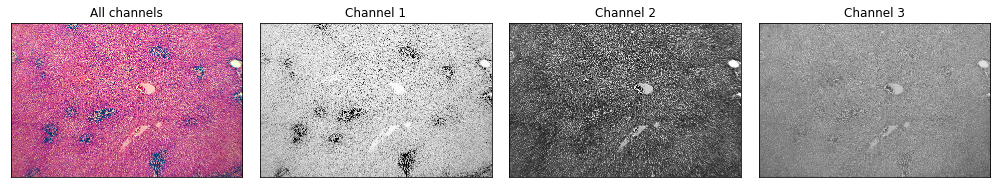

In [2]:
# Load the data, and look for a hint of where to start first
widefield_image_file = "data/Sheep11-4x-77.jpg"
image = transform.rescale(io.imread(widefield_image_file), 0.25)

plot_image(image)

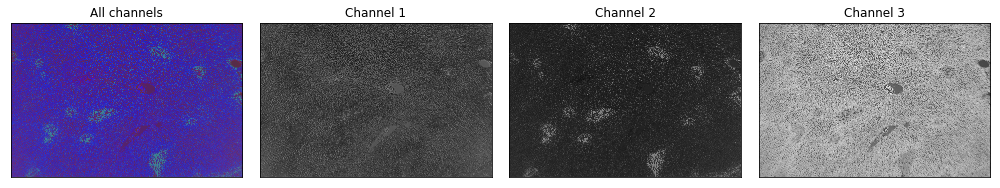

In [3]:
# Perform a colour deconvolution
heu = color.separate_stains(image, colour_deconv_matrix).astype(float)

plot_image(heu)

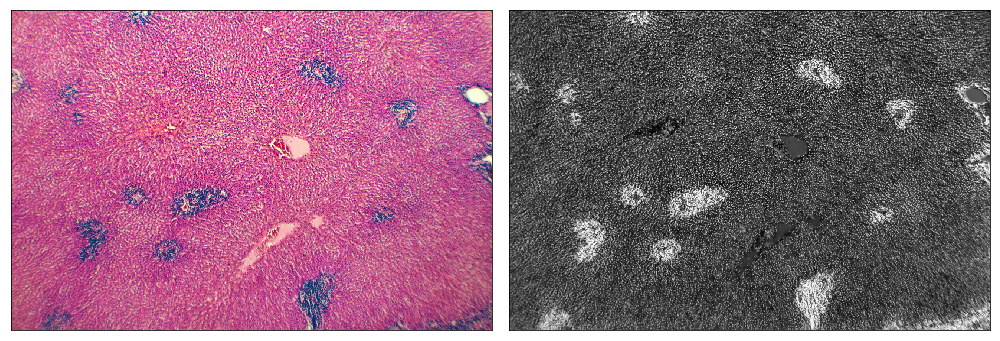

In [4]:
# Apply CLAHE on the haematoxylin channel
rescaled = exposure.rescale_intensity(heu[:, :, 1], out_range=(0, 1))
equalised_hist = exposure.equalize_adapthist(rescaled)

plot_image(np.dstack((image, equalised_hist)))

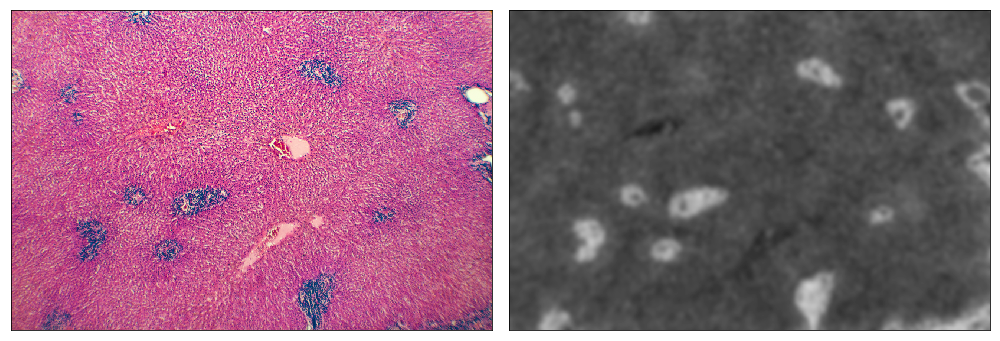

In [5]:
# Apply Gaussian blur
blurred = filters.gaussian(equalised_hist, 7)

plot_image(np.dstack((image, blurred)))

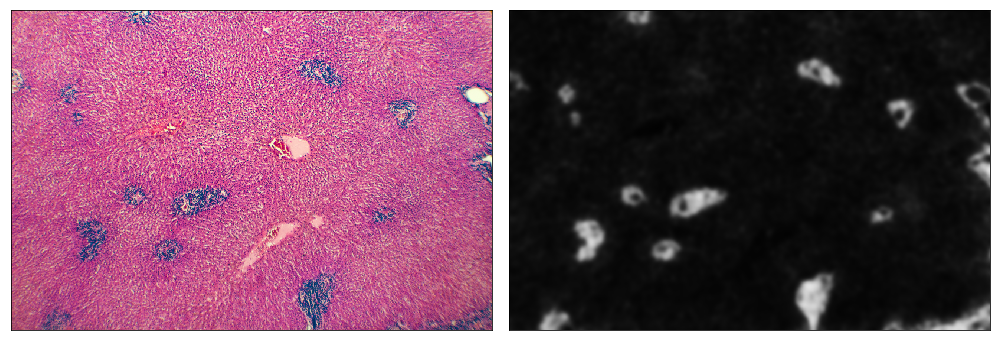

In [6]:
# Sigmoid transform for contrast
contrast = exposure.adjust_sigmoid(blurred, cutoff=0.6)

plot_image(np.dstack((image, contrast)))

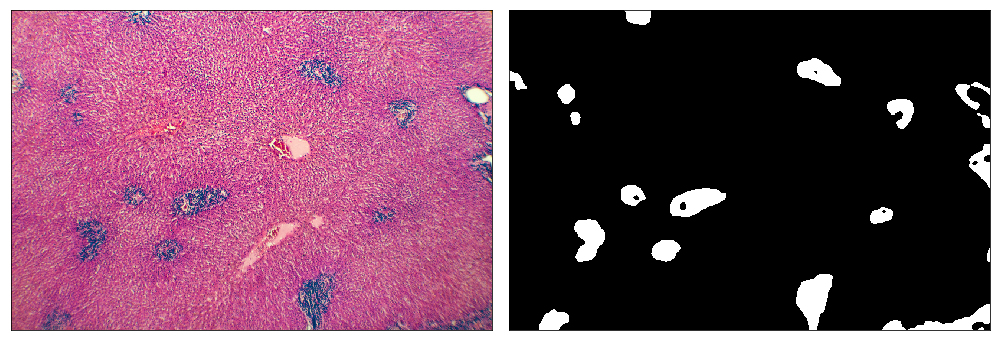

In [7]:
# Apply an adaptive threshold
thresholded = contrast > filters.threshold_local(contrast, 351, offset=-0.1)

plot_image(np.dstack((image, thresholded)))

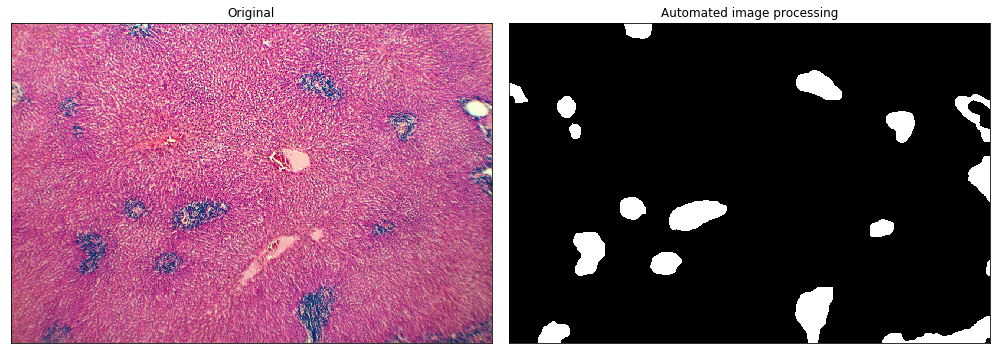

In [8]:
# Use a maximum filter followed by a binary closing to fill any holes
enlarged = maximum_filter(thresholded, 5)
inflammation = morphology.closing(enlarged, morphology.disk(11))

plot_image(np.dstack((image, inflammation)), titles=["Original", "Automated image processing"])

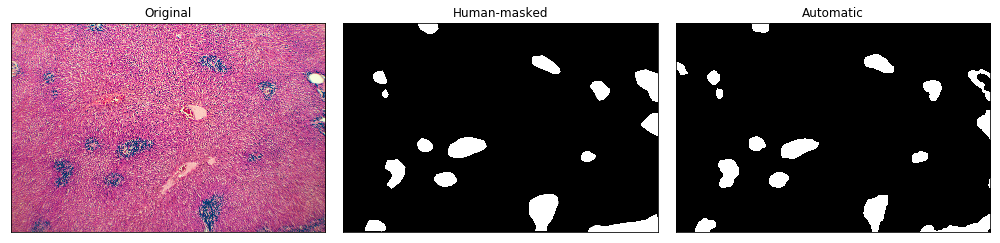

In [9]:
# Load up the human mask and visualise everything together
mask = transform.rescale(io.imread("data/Sheep11-4x-77.jpg_mask.jpg"), 0.25)

plot_image(np.dstack((image, mask, inflammation)), titles=["Original", "Human-masked", "Automatic"])

In [10]:
# Let's use a convolutional encoder-decoder network to find inflammatory zones
from keras.models import load_model

model = load_model("models/histo_convnet.hdf5")
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_206 (Conv2D)          (None, 432, 648, 32)      896       
_________________________________________________________________
conv2d_207 (Conv2D)          (None, 432, 648, 32)      9248      
_________________________________________________________________
conv2d_208 (Conv2D)          (None, 432, 648, 32)      9248      
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 216, 324, 32)      0         
_________________________________________________________________
conv2d_209 (Conv2D)          (None, 216, 324, 64)      18496     
_________________________________________________________________
conv2d_210 (Conv2D)          (None, 216, 324, 64)      36928     
_________________________________________________________________
conv2d_211 (Conv2D)          (None, 216, 324, 64)      36928     
__________

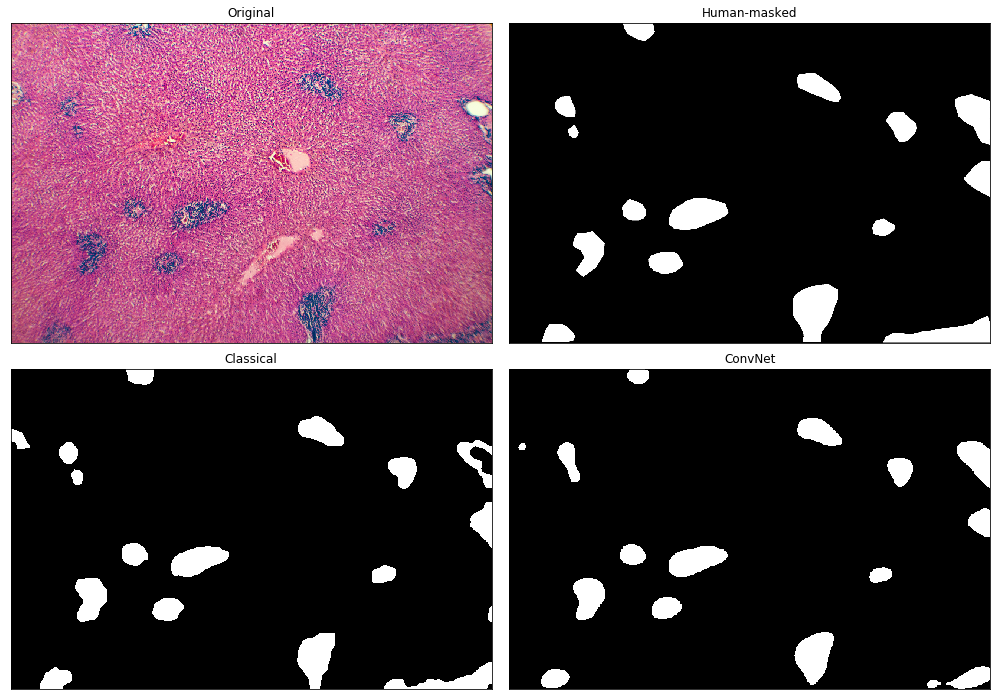

In [11]:
# Use the convnet to find the inflammatory zones, and compare with our work so far
nn_image = transform.rescale(image, 0.5)
pred = model.predict(nn_image.reshape(1, *nn_image.shape)).squeeze()

plot_grid((image, mask, inflammation, pred > 0.5), ["Original", "Human-masked", "Classical", "ConvNet"])